Testing the code from Kjersti`s github calculating the mixed layer depth. 

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
#CODE implemented from Kjersti:
#from roppy import SGrid
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import griddata
from glob import glob
import time
import xarray as xr
import sys
import os
from dens_func import dens
import matplotlib.pyplot as plt 
import cartopy 
import cmocean 
import cartopy.crs as ccrs 

In [54]:
def MLD(pot_dens, z):
    '''
    Calculate Mixed Layer Depth (MLD) based on potential density profile and depth.
    MLD is where the potential density exceeds a threshold, here set to be surface
    potential density + 0.03 kgm-3.

    Parameters:
    - pot_dens: 1D numpy array of potential density [kg/m^3]
    - z: 1D numpy array of corresponding depth levels [m] (negative downward)

    Returns:
    - mld: scalar value of MLD [m], or local water depth if no depth exceeds threshold,
    meaning full water column is mixed.
    '''
    # Remove NaNs
    valid = ~np.isnan(pot_dens)
    pot_dens = pot_dens[valid]
    z = z[valid]

    if len(pot_dens) == 0:
        return print(f"Length of potential density input is equal to zero. Retuned value is a nan value: {np.nan}")

    # Surface density
    surface_density = pot_dens[-1]
    threshold = surface_density + 0.003  # MLD is where density exceeds surface + 0.03

    # Find where density exceeds threshold
    exceed = np.where(pot_dens >= threshold)[0]

    if exceed.size == 0:
        return print(f"No depth exceeds treshold. First value of z is returned: {z[-1]}")  # no depth exceeds threshold

    # Return the first depth where threshold is exceeded
    return print(f"The first depth where the treshold is exceeded is: {z[exceed[0]]}") 


In [55]:
ds_2024 = xr.open_dataset(f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240330.nc').isel( time = 0, X = 360, Y = 760)

In [71]:
ds_2024.head()
#ds_2024.dims

<xarray.Dataset> Size: 18kB
Dimensions:           (time: 5, Y: 5, X: 5, s_rho: 5, s_w: 5)
Coordinates:
  * time              (time) datetime64[ns] 40B 2024-03-30 ... 2024-03-30T04:...
  * s_rho             (s_rho) float64 40B -0.9799 -0.9403 ... -0.8634 -0.8261
  * X                 (X) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * Y                 (Y) float64 40B 0.0 800.0 1.6e+03 2.4e+03 3.2e+03
  * s_w               (s_w) float64 40B -1.0 -0.96 -0.9208 -0.8823 -0.8446
    lon               (Y, X) float64 200B ...
    lat               (Y, X) float64 200B ...
Data variables: (12/18)
    Uwind_eastward    (time, Y, X) float32 500B ...
    Vwind_northward   (time, Y, X) float32 500B ...
    zeta              (time, Y, X) float32 500B ...
    ubar_eastward     (time, Y, X) float32 500B ...
    vbar_northward    (time, Y, X) float32 500B ...
    u_eastward        (time, s_rho, Y, X) float32 2kB ...
    ...                ...
    hc                float64 8B ...
    Cs_r              (s_rho) float64 40B ...
    Cs_w              (s_w) float64 40B ...
    h                 (Y, X) float32 100B ...
    projection_stere  int32 4B ...
    depth             int32 4B ...
Attributes: (12/33)
    id:                      15f95603-12d1-4e0f-8cbe-33946594447f
    naming_authority:        no.met
    operational_status:      scientific
    iso_topic_category:      oceans
    activity_type:           Numerical Simulation
    keywords_vocabulary:     GCMDSK:GCMD Science Keywords:https://gcmd.earthd...
    ...                      ...
    project:                 Norkyst_v3
    license:                 https://spdx.org/licenses/CC-BY-4.0 (CC-BY-4.0)
    title:                   Norkyst-800m - ROMS, Norkyst-800m ocean hindcast...
    summary:                 Norkyst-800m (Norwegian Coast 800m horizontal re...
    title_no:                Hindcast prognoser fra havmodellen Norkyst-800m,...
    summary_no:              NorKyst-800m (Norske kystområder med 800m horiso...

In [22]:
temp = ds_2024.temperature.transpose() 
salinity = ds_2024.salinity.transpose() 


In [56]:
#Note: Long name of temp is pot temp, meaning the pressure effects are already counted for and does not need to be changed for the NorKyst model. 
#If applied to the infer results - double check wether the temperature is potential temp or not when comparing mld for more layers than the surface.
pot_dens = dens(temp, salinity)
pot_dens = pot_dens.values

In [8]:
#Check if the shape of pot_dens matches the needed shape to use in the mld function
"""
print(f"The shape of the potential density is: {pot_dens.shape}")
print(f"The dims of potential density is: {pot_dens.dims}")
pot_dens = pot_dens.values
print(f"The shape of the potential density is: {pot_dens.shape}")
#pot_dens = pot_dens.stack()
"""

'\nprint(f"The shape of the potential density is: {pot_dens.shape}")\nprint(f"The dims of potential density is: {pot_dens.dims}")\npot_dens = pot_dens.values\nprint(f"The shape of the potential density is: {pot_dens.shape}")\n#pot_dens = pot_dens.stack()\n'

In [7]:
def transformation(ds_name):
    #Define necessary variables used for the transformation from s_layer to depth
    hc = ds_name["hc"] #Critical depth for stretching
    cs_r = ds_name["Cs_r"] #stretching curve at rho points
    zeta = ds_name["zeta"] #.fillna(0) #free-surface 
    H = ds_name["h"] #bathymetry at rho-points (depth)
    #Vtransform = ds_name["Vtransform"] Not in this dataset
    s_rho = ds_name["s_rho"] #range 1,40. 40 is surface layer

    #Transformation process
    Z_0_rho = (hc * s_rho + cs_r * H) / (hc + H)
    z_rho = zeta + (zeta + H) * Z_0_rho

    ds_name.coords["z_rho"] = z_rho.transpose() #Corrects the dimensions

In [58]:
transformation(ds_2024) #z_rho explains the depth for a given grid cell, not sure if this is ideal yet. We will find out. 

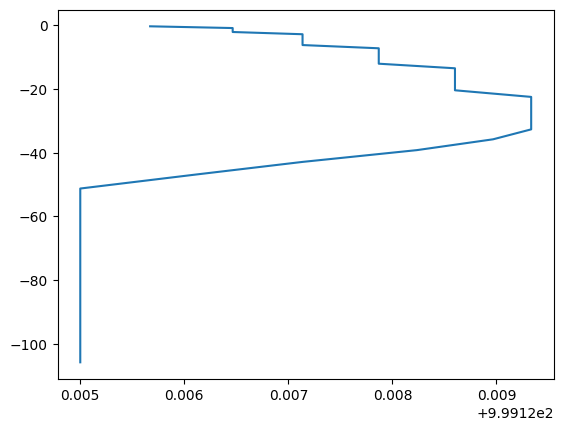

In [59]:
#Check if it works - and check shape
#ds_2024.z_rho
#np.set_printoptions(np.inf)
z_rho = ds_2024.z_rho.values
#print(z_rho)
#print(f"The shape of z_rho is: {z_rho.shape}")
plt.plot(pot_dens, z_rho)

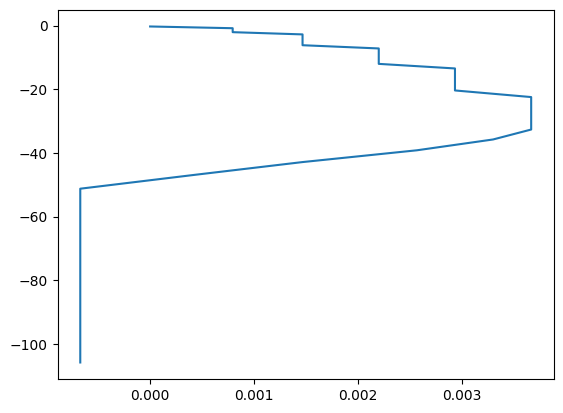

In [60]:
diff = (pot_dens - pot_dens[-1])
plt.plot(diff, z_rho)

In [61]:
MLD(pot_dens = pot_dens, z = z_rho)

The first depth where the treshold is exceeded is: -35.7897845696111


In [35]:
#Testing another area
ds_2024_new = xr.open_dataset(f'/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240621.nc').isel(s_rho =-1,time = 0,X = slice(722,985), Y = slice(1601,1892))

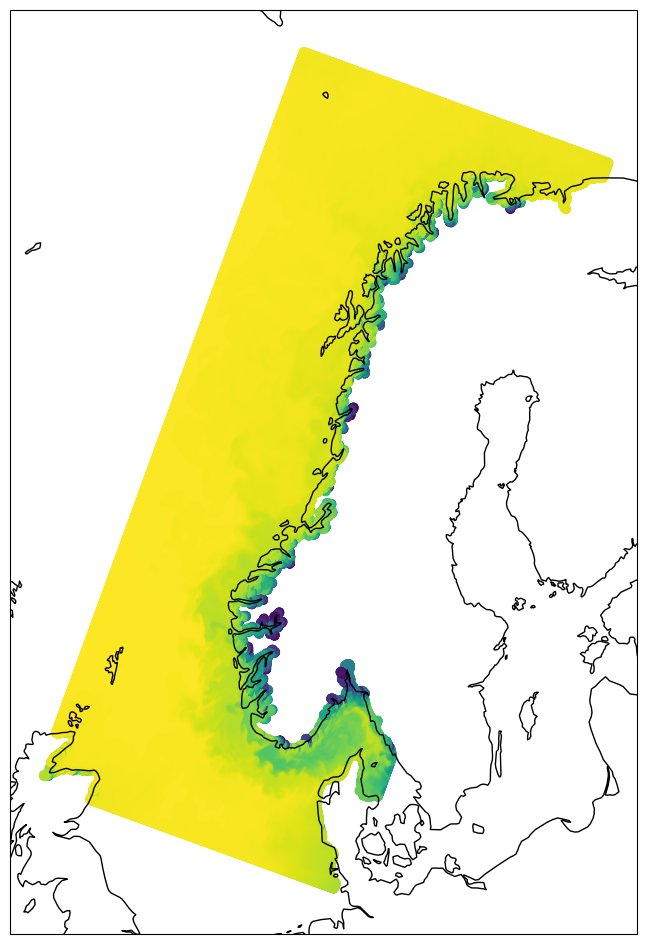

In [14]:
fig,ax = plt.subplots(figsize = (10,12), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.scatter(ds_2024_new["lon"], ds_2024_new["lat"], c = ds_2024_new["salinity"][:,:],transform = ccrs.PlateCarree())
ax.coastlines()

In [36]:
temp_n = ds_2024_new["temperature"].where(ds_2024_new["sea_mask"] == 1)
temp_n = temp_n.transpose()
salinity_n = ds_2024_new["salinity"].where(ds_2024_new["sea_mask"] == 1)
salinity_n = salinity_n.transpose()

In [41]:
pot_dens_n = dens(temp_n,salinity_n)
pot_dens_n = pot_dens_n.values

In [38]:
transformation(ds_2024_new)
z_rho_n = ds_2024_new.z_rho.values

In [39]:
mld = MLD(pot_dens=pot_dens_n, z = z_rho_n)

Length of potential density input is equal to zero. Retuned value is a nan value: nan


It seems like it might be working? Look up which areas and radiuses are interesting to look at. Also it might be relevant to see the mld of longer time periods than just the first hour. Seasonal changes are also intersting. 

1. Plot the MLD found from the first two datasets for an example as a seaborn heatmap or with depth? 
2. Check for a longer period of time. 
3. Make seasonal plots of monthly means for an example. 

In [19]:
import seaborn as sns


In [ ]:
def arrays(file_str):

    ds_name = xr.open_dataset(file_str)
    ds_name = ds_name.resample(time = "D").mean()
    
    #z_rho using the transformation function
    transformation(ds_name=ds_name)
    z_rho = ds_name["z_rho"].transpose("time", "s_rho", "Y", "X")
    print(z_rho.shape)    
    #variables 
    time = ds_name["time"]
    salt = ds_name["salinity"]
    temp = ds_name["temperature"]
    mask = ds_name["sea_mask"]
    print(salt.shape)
    print(mask.shape)


    #temporary arrays
    tmpd = np.full((salt.shape[0], z_rho.shape[1], salt.shape[2], salt.shape[3]), np.nan) #potential density, time, s_rho, x and y 
    tmmld = np.full((salt.shape[0], salt.shape[2], salt.shape[3]), np.nan) #mixed layer - time, x and y 
    print(tmpd.shape)
    print(tmmld.shape)

    # Looping through grid points
    for y in range(0, salt.shape[2]):
        for x in range(0, salt.shape[3]): 
            if not mask[y, x]:  # skipping land points
               continue

            t = -1
            z_rho_v = z_rho[t,:,y,x]
            salt_v = salt[t,:,y,x]
            temp_v = temp[t,:,y,x]

            dens_profile = dens(salt_v, temp_v, np.zeros_like(z_rho_v))
            tmpd[t,:,y,x] = dens_profile

            tmmld[t,y,x] = MLD(dens_profile, z_rho_v) 
            

    ds_mld = xr.Dataset(
        data_vars=dict( 
        pd = (["time", "z_rho", "Y", "X"], tmpd, {"units":"kg m^{-3}", "Name" : "Potential Density"}),
        mld = (["time", "Y", "X"], tmmld, {"units":"meter", "Name":"Mixed Layer Depth"})
        ),
        coords=dict(
            time = time,
            z_rho = ds_name["z_rho"].values,
            Y = ds_name["Y"].values, 
            X = ds_name["X"].values)
            )

    return ds_mld


In [73]:
arrays(file_str='/lustre/storeB/project/fou/hi/foccus/datasets/symlinks/norkystv3-hindcast/2024/norkyst800-20240330.nc')

MemoryError: Unable to allocate 5.64 GiB for an array with shape (24, 40, 1148, 2747) and data type int16